In [10]:
import numpy as np
import pandas as pd
import networkx as nx
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import folium
import ssl
import certifi
import geopy

ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx

"""
cities = [
    "Rouen", "Le Petit-Quevilly",
    "La Bouille", "Deville-les-Rouen",
    "Saint-Martin-du-Vivier",
    "Le Mesnil-Esnard", "Boos", "Saint-Etienne-du-Rouvray", "Oissel",
    "Grand-Couronne", "Quevillon"
]
"""
cities = [
    "Rouen", "Le Petit-Quevilly", "Le Grand-Quevilly", "Petit-Couronne", 
    "Canteleu", "Sahurs", "La Bouille", "Moulineaux", "Saint-Martin-de-Boscherville", "Hénouville", "Deville-les-Rouen", "Bois-Guillaume", 
    "Saint-Martin-du-Vivier", "Bonsecours", "Saint-Aubin-Epinay", 
    "Le Mesnil-Esnard", "Amfreville-la-Mi-Voie", "Franqueville-Saint-Pierre", 
    "Belbeuf", "Boos", "Saint-Etienne-du-Rouvray", "Oissel", "Sotteville-les-Rouen",
    "Grand-Couronne", "Le Val Adam", "Quevillon", "Saint-Aubin-Celloville"
]

geolocator = Nominatim(user_agent="vrp_france")

locations = {}
for city in cities:
    location = geolocator.geocode(city + ", France")
    locations[city] = (location.latitude, location.longitude)

G = nx.Graph()

for city, coord in locations.items():
    G.add_node(city, pos=coord)

distances = {}
for city1 in cities:
    for city2 in cities:
        if city1 != city2:
            distance = geodesic(locations[city1], locations[city2]).km
            G.add_edge(city1, city2, weight=distance)
            distances[(city1, city2)] = distance

adj_matrix = nx.adjacency_matrix(G, weight='weight').todense()
df_adj_matrix = pd.DataFrame(adj_matrix, index=cities, columns=cities)
print("Matrice d'adjacence des distances (en km) :\n", df_adj_matrix)
df_adj_matrix.to_markdown("matrice_adjacence_distances.md")
cities_count = len(cities)


Matrice d'adjacence des distances (en km) :
                                   Rouen  Le Petit-Quevilly  Le Grand-Quevilly  \
Rouen                          0.000000           2.963495           4.872609   
Le Petit-Quevilly              2.963495           0.000000           2.050419   
Le Grand-Quevilly              4.872609           2.050419           0.000000   
Petit-Couronne                 7.870359           5.116914           3.066657   
Canteleu                       4.413453           3.579861           5.011678   
Sahurs                        14.201793          11.238972           9.445896   
La Bouille                    15.416571          12.453464          10.661766   
Moulineaux                    14.431530          11.532842           9.559303   
Saint-Martin-de-Boscherville   9.518633           7.538857           7.593936   
Hénouville                    10.746277           9.701545          10.425535   
Deville-les-Rouen              4.561632           5.166462      

Matrice de distances:
 [[ 0.         85.10754188 11.66635837 ... 16.76853924 31.08041329
  57.00275658]
 [85.10754188  0.         45.65484178 ... 87.47327047 67.40037656
  52.53426127]
 [11.66635837 45.65484178  0.         ... 34.99980102 83.27004047
  62.39531124]
 ...
 [16.76853924 87.47327047 34.99980102 ...  0.         71.64728687
  34.33097304]
 [31.08041329 67.40037656 83.27004047 ... 71.64728687  0.
  32.72392453]
 [57.00275658 52.53426127 62.39531124 ... 34.33097304 32.72392453
   0.        ]]


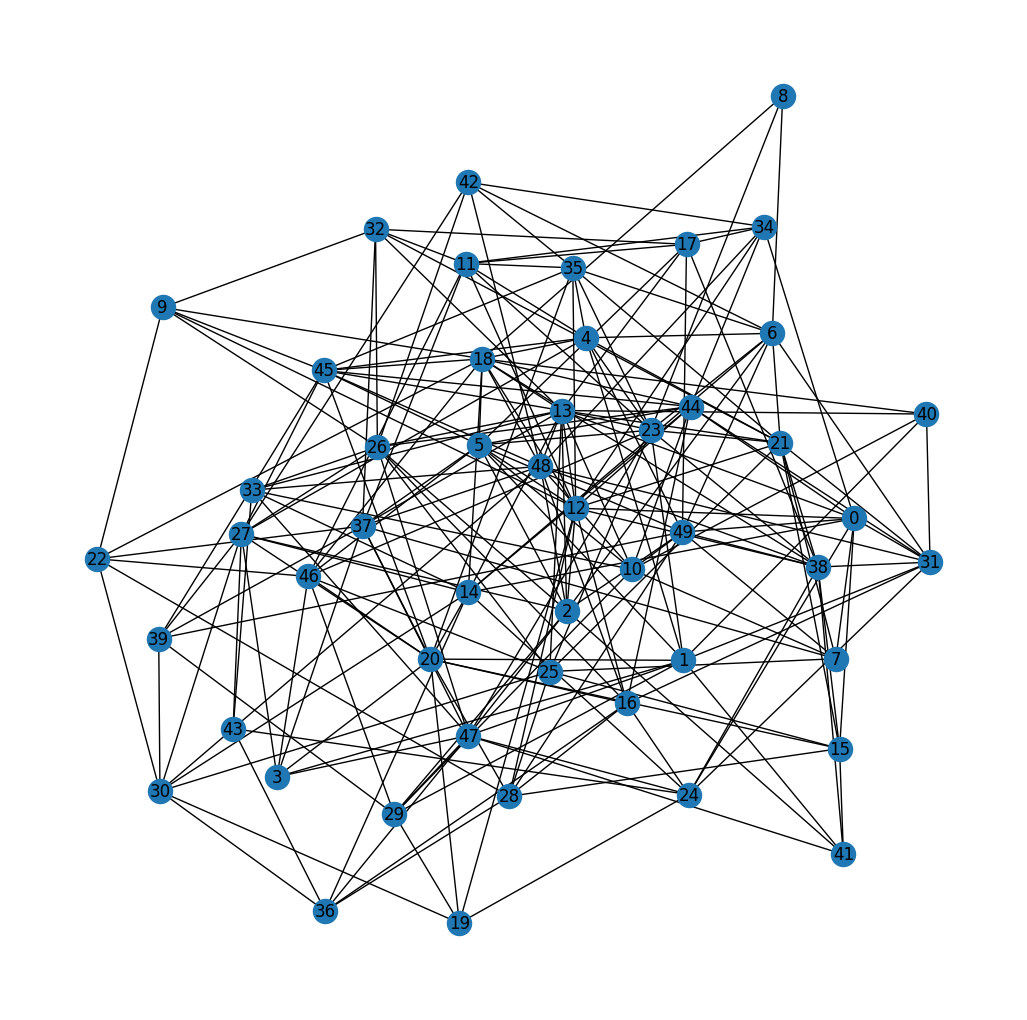

In [95]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


cities_count = 50

mat = np.random.random((cities_count, cities_count))
mat = mat + mat.T
np.fill_diagonal(mat, 0)

adj_matrix = mat * cities_count
print("Matrice de distances:\n", adj_matrix)
G = nx.binomial_graph(50,0.2)
pos = nx.spring_layout(G)

fig, ax = plt.subplots(1, 1, figsize=(13, 13))
nx.draw(G, pos, with_labels=True, ax=ax)
plt.show()


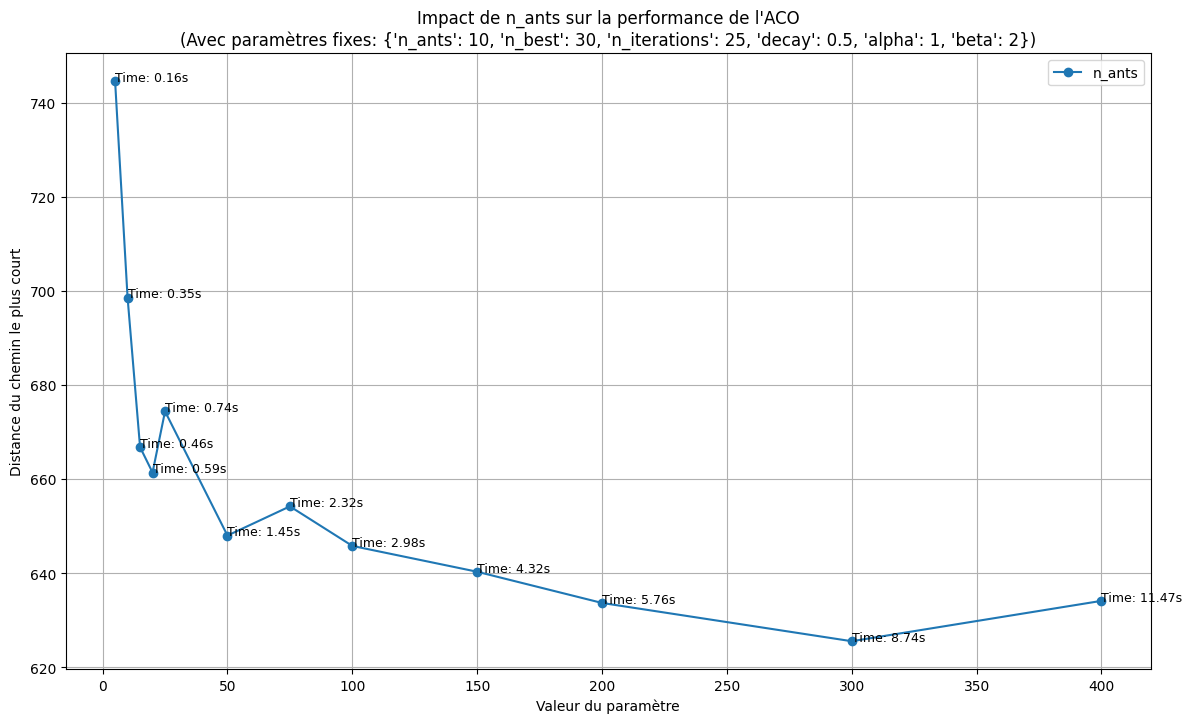

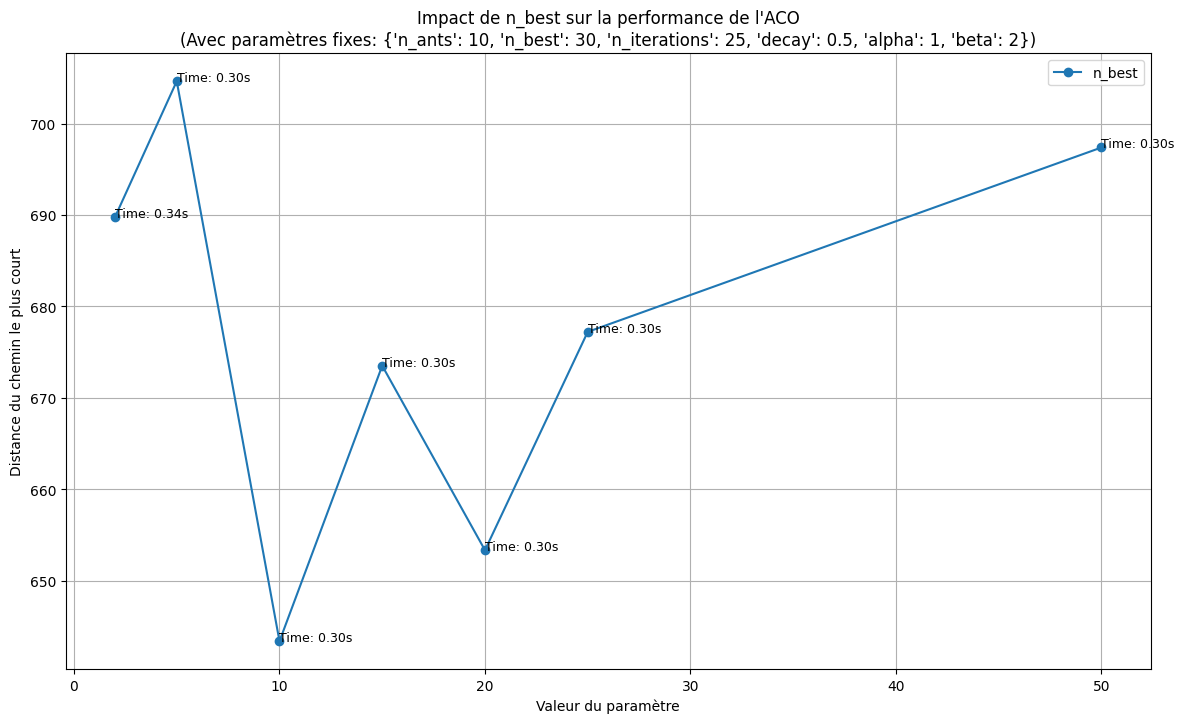

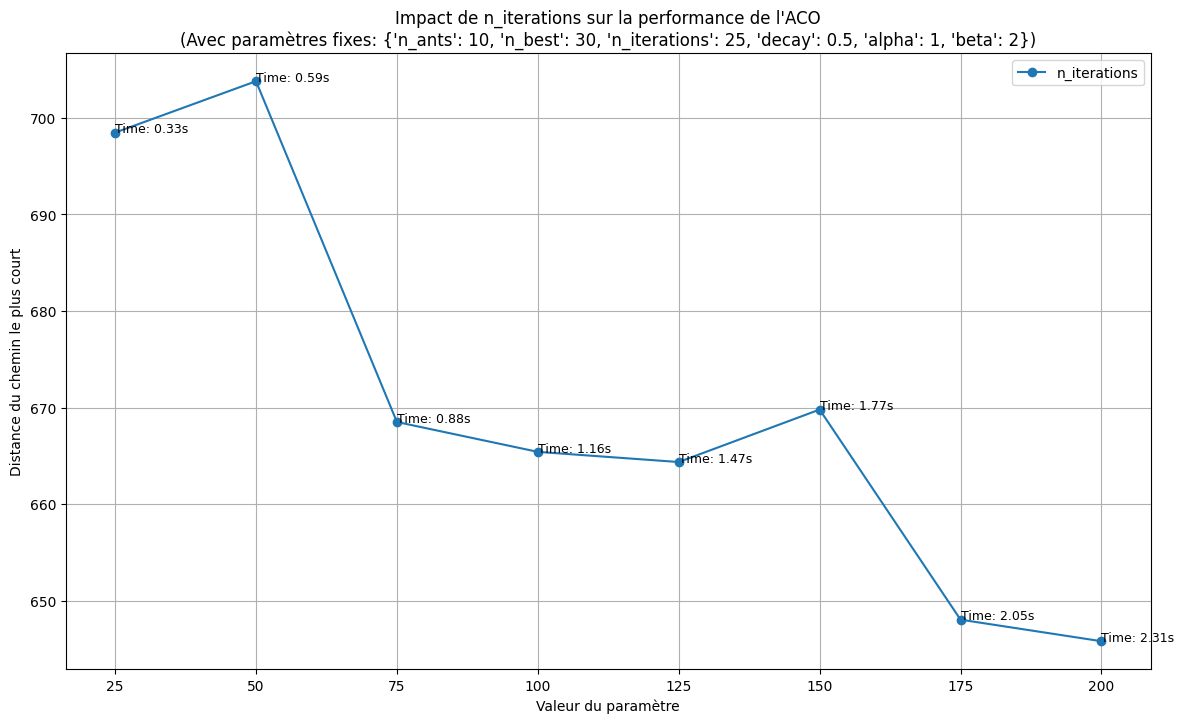

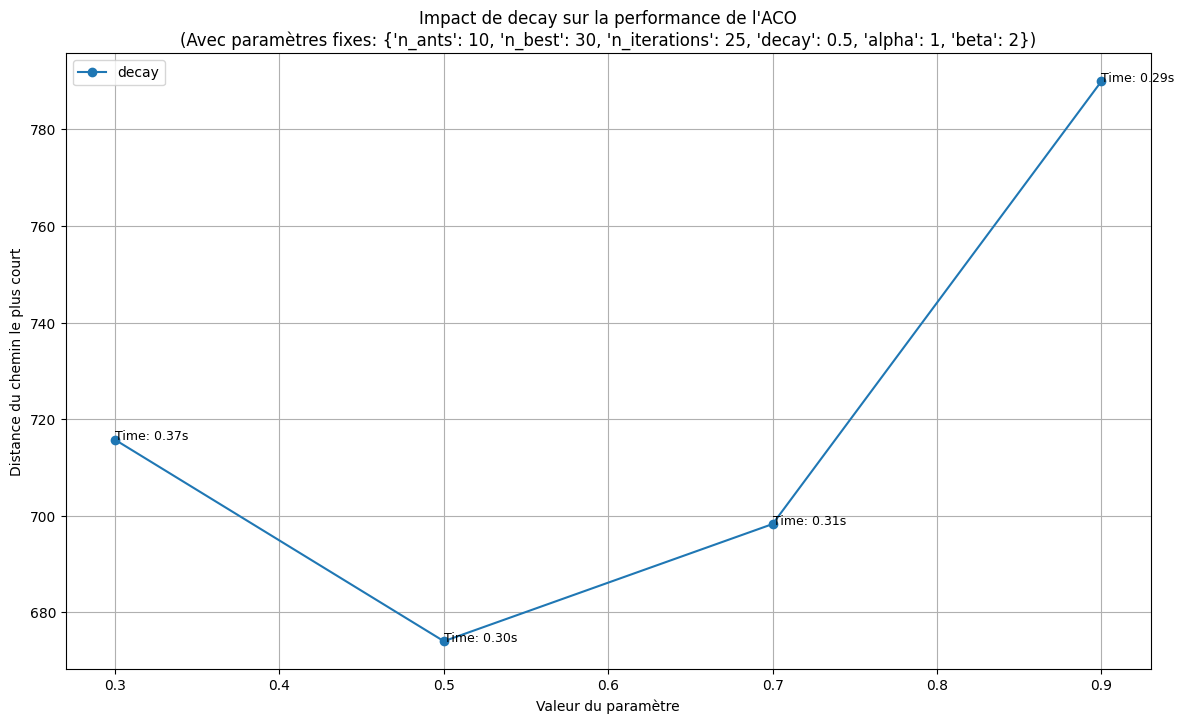

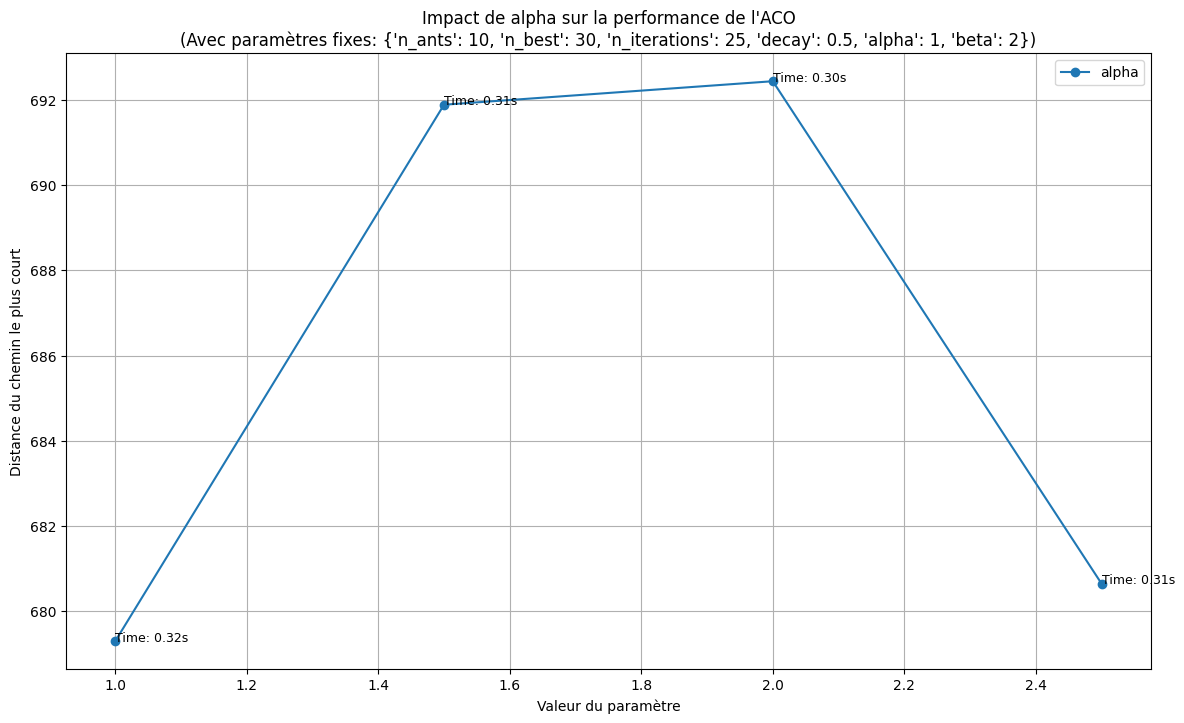

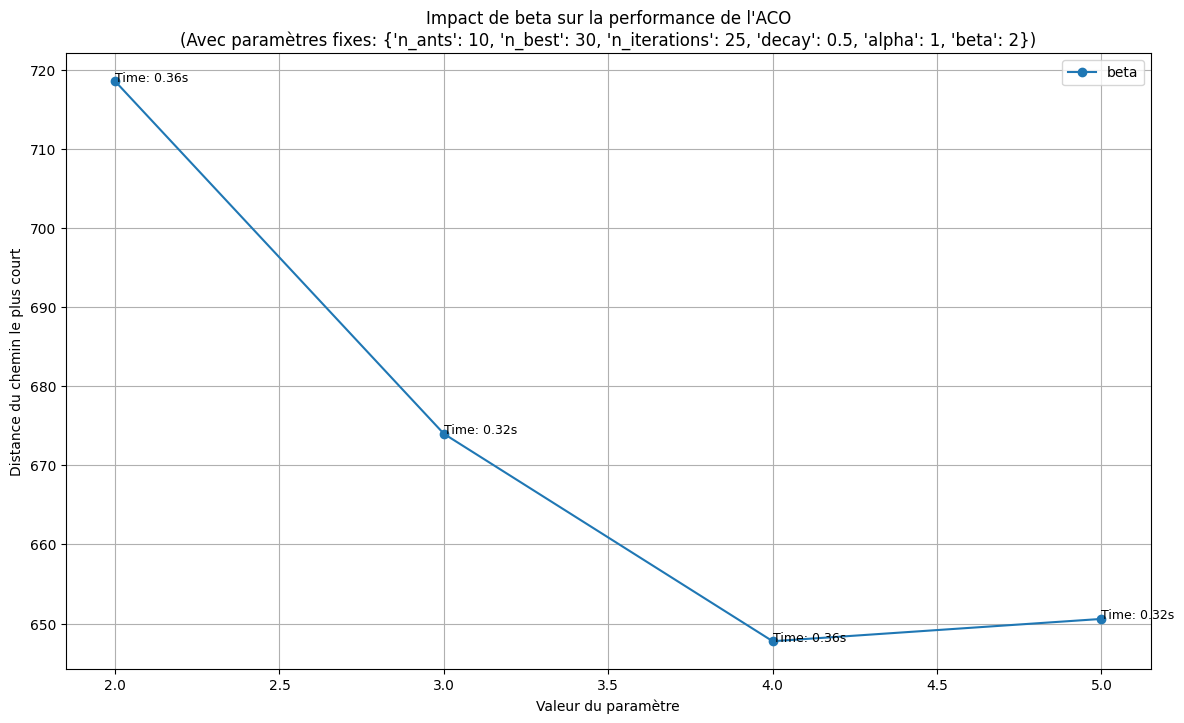

In [89]:
import time
import os
import cv2

def create_graph(cities_count, complete=True, threshold=0.5):
    mat = np.random.random((cities_count, cities_count))
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    adj_matrix = mat * cities_count
    if not complete:
        adj_matrix[adj_matrix < threshold] = 0  # Appliquer un seuil pour éliminer certaines arêtes
    G = nx.from_numpy_array(adj_matrix)
    if not nx.is_connected(G):
        raise ValueError("Le graphe généré n'est pas connecté. Essayez de régénérer la matrice.")
    return G, adj_matrix

def gen_path(start, pheromone, distances, alpha, beta):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for _ in range(len(distances) - 1):
        move = pick_move(pheromone[prev, :], distances[prev, :], visited, alpha, beta)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start))  
    return path

def pick_move(pheromone_row, dist_row, visited, alpha, beta):
    pheromone_row = np.copy(pheromone_row)
    pheromone_row[list(visited)] = 0

    dist_row[dist_row == 0] = np.inf
    with np.errstate(divide='ignore'):
        row = pheromone_row ** alpha * ((1.0 / dist_row) ** beta)
    
    row = np.nan_to_num(row)
    norm_row = row / row.sum()
    move = np.random.choice(range(len(pheromone_row)), 1, p=norm_row)[0]
    return move

def gen_all_paths(n_ants, pheromone, distances, alpha, beta):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, distances, alpha, beta)
        all_paths.append((path, calc_path_length(path, distances)))
    return all_paths

def calc_path_length(path, distances):
    total_dist = 0
    for (i, j) in path:
        total_dist += distances[i, j]
    return total_dist

def spread_pheromone(all_paths, pheromone, n_best, decay):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / dist
    pheromone *= decay

def run_aco(n_ants, n_best, n_iterations, decay, alpha, beta):
    pheromone = np.ones(adj_matrix.shape) / cities_count
    all_time_shortest_path = ("placeholder", np.inf)
    paths = [] 
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, adj_matrix, alpha, beta)
        spread_pheromone(all_paths, pheromone, n_best, decay)
        shortest_path = min(all_paths, key=lambda x: x[1])
        paths.append(shortest_path[0]) 
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path
    return all_time_shortest_path[1], paths

def draw_graph(path, iteration, param, value):
    plt.figure(figsize=(30, 20))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='white', width=1)
    edge_list = [(i, j) for i, j in path]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='r', width=2)
    plt.title(f"{param}={value}: Chemin trouvé à l'itération {iteration}")
    folder = f'graph/{param}_{value}'
    if not os.path.exists(folder):
        os.makedirs(folder)
    plt.savefig(f'{folder}/path_iteration_{iteration:05d}.jpeg')
    plt.close()

params = {
    "n_ants": [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 300, 400],
    "n_best": [2,5,10,15,20,25,50],
    "n_iterations": [25, 50, 75, 100, 125, 150, 175, 200],
    "decay": [0.3, 0.5, 0.7, 0.9],
    "alpha": [1, 1.5, 2, 2.5],
    "beta": [2, 3, 4, 5]
}

default_params = {
    "n_ants": 10,
    "n_best": 30,
    "n_iterations": 25,
    "decay": 0.5,
    "alpha": 1,
    "beta": 2
}

for param, values in params.items():
    param_results = []
    for value in values:
        kwargs = default_params.copy()
        kwargs[param] = value
        
        start_time = time.time()
        distance, paths = run_aco(**kwargs)
        exec_time = time.time() - start_time
        
        param_results.append((param, value, distance, exec_time))
        for iteration, path in enumerate(paths):
            draw_graph(path, iteration, param, value)
    
    df_param_results = pd.DataFrame(param_results, columns=["param", "value", "distance", "exec_time"])
    df_param_results.to_csv(f'results_{param}.csv', index=False)

    plt.figure(figsize=(14, 8))
    plt.plot(df_param_results["value"], df_param_results["distance"], marker='o', label=f'{param}')
    for idx, row in df_param_results.iterrows():
        plt.text(row["value"], row["distance"], f'Time: {row["exec_time"]:.2f}s', fontsize=9)
    plt.xlabel('Valeur du paramètre')
    plt.ylabel('Distance du chemin le plus court')
    plt.title(f"Impact de {param} sur la performance de l'ACO\n(Avec paramètres fixes: {default_params})")
    plt.legend()
    plt.grid(True)
    plt.show()

os.makedirs("graph", exist_ok=True)
for param in params.keys():
    for value in params[param]:
        image_folder = f'graph/{param}_{value}'
        video_name = f'graph/animation_{param}_{value}.mp4'

        if not os.path.exists(image_folder):
            continue

        images = [img for img in os.listdir(image_folder) if img.endswith(".jpeg")]
        images.sort()

        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 3, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()



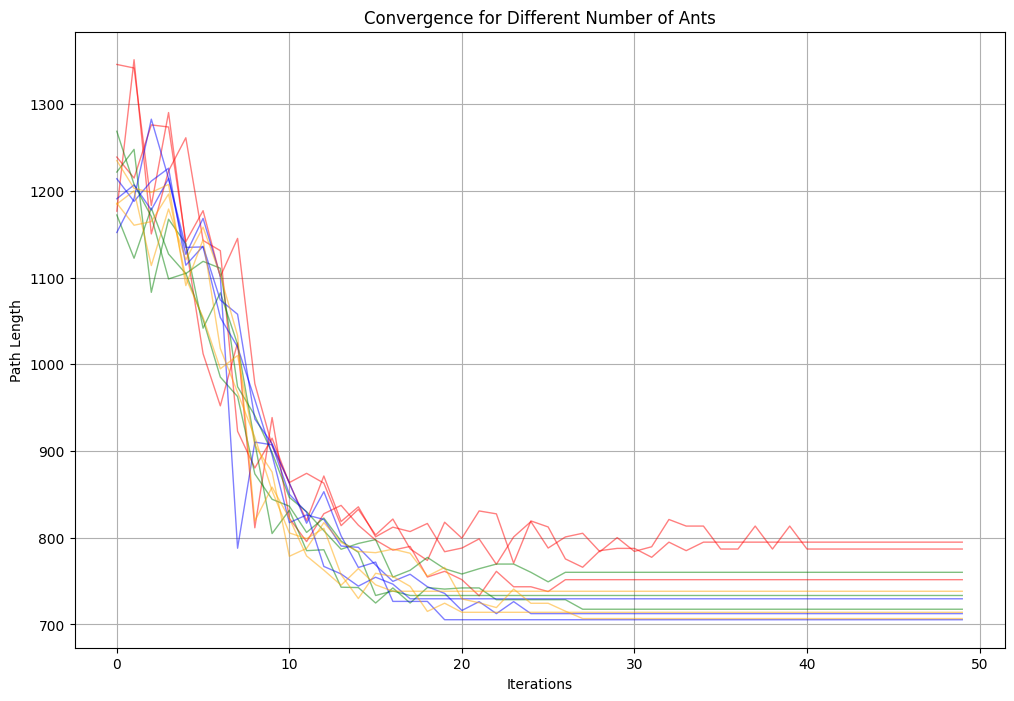

In [109]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def create_graph(cities_count, complete=True, threshold=0.5):
    mat = np.random.random((cities_count, cities_count))
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    adj_matrix = mat * cities_count
    if not complete:
        adj_matrix[adj_matrix < threshold] = 0  # Appliquer un seuil pour éliminer certaines arêtes
    G = nx.from_numpy_array(adj_matrix)
    if not nx.is_connected(G):
        raise ValueError("Le graphe généré n'est pas connecté. Essayez de régénérer la matrice.")
    return G, adj_matrix

def gen_path(start, pheromone, distances, alpha, beta):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for _ in range(len(distances) - 1):
        move = pick_move(pheromone[prev, :], distances[prev, :], visited, alpha, beta)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start))
    return path

def pick_move(pheromone_row, dist_row, visited, alpha, beta):
    pheromone_row = np.copy(pheromone_row)
    pheromone_row[list(visited)] = 0
    dist_row[dist_row == 0] = np.inf
    with np.errstate(divide='ignore'):
        row = pheromone_row ** alpha * ((1.0 / dist_row) ** beta)
    row = np.nan_to_num(row)
    norm_row = row / row.sum()
    move = np.random.choice(range(len(pheromone_row)), 1, p=norm_row)[0]
    return move

def gen_all_paths(n_ants, pheromone, distances, alpha, beta):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, distances, alpha, beta)
        all_paths.append((path, calc_path_length(path, distances)))
    return all_paths

def calc_path_length(path, distances):
    total_dist = 0
    for (i, j) in path:
        total_dist += distances[i, j]
    return total_dist

def spread_pheromone(all_paths, pheromone, n_best, decay):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / dist
    pheromone *= decay

def run_aco(n_ants, n_best, n_iterations, decay, alpha, beta):
    pheromone = np.ones(adj_matrix.shape) / cities_count
    all_time_shortest_path = ("placeholder", np.inf)
    path_lengths = []
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, adj_matrix, alpha, beta)
        spread_pheromone(all_paths, pheromone, n_best, decay)
        shortest_path = min(all_paths, key=lambda x: x[1])
        path_lengths.append(shortest_path[1])
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path
    return all_time_shortest_path[1], path_lengths

def execute_and_measure(n_ants_values, n_best, n_iterations, decay, alpha, beta, runs=3):
    execution_times = []
    path_distances = []
    path_convergences = []
    for n_ants in n_ants_values:
        for _ in range(runs):
            G, adj_matrix = create_graph(cities_count, complete=True)
            start_time = time.time()
            distance, path_lengths = run_aco(n_ants, n_best, n_iterations, decay, alpha, beta)
            exec_time = time.time() - start_time
            execution_times.append((n_ants, exec_time))
            path_distances.append((n_ants, distance))
            path_convergences.append((n_ants, path_lengths))
    return execution_times, path_distances, path_convergences

def plot_convergence(convergences, n_ants_values, title, filename):
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'orange']
    for n_ants, convergence in convergences:
        color = colors[n_ants_values.index(n_ants) % len(colors)]
        plt.plot(convergence, color=color, alpha=0.5,linewidth=1)
    plt.xlabel('Iterations')
    plt.ylabel('Path Length')
    plt.title(title)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Parameters for ACO
n_best = 5
n_iterations = 50
decay = 0.5
alpha = 1
beta = 2

# Experiment: Convergence with varying number of ants
cities_count = 40
n_ants_values = [10, 20, 30, 40]
execution_times, path_distances, convergences = execute_and_measure(n_ants_values, n_best, n_iterations, decay, alpha, beta, runs=3)

# Plot the convergence for different number of ants
plot_convergence(convergences, n_ants_values, 'Convergence for Different Number of Ants', 'convergence_varying_ants.png')

# Save the execution times and path distances
execution_times_df = pd.DataFrame(execution_times, columns=['n_ants', 'execution_time'])
path_distances_df = pd.DataFrame(path_distances, columns=['n_ants', 'path_distance'])
execution_times_df.to_csv('execution_times_varying_ants.csv', index=False)
path_distances_df.to_csv('path_distances_varying_ants.csv', index=False)


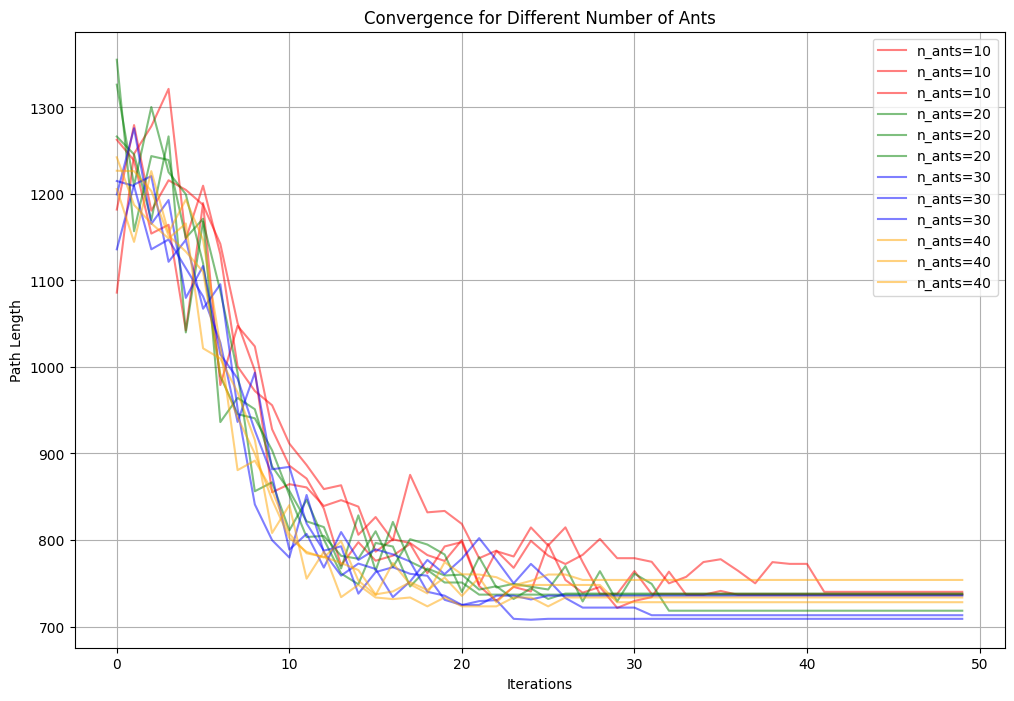

TypeError: run_aco() missing 1 required positional argument: 'n_ants'

In [110]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
import pandas as pd

def create_graph(cities_count, complete=True, threshold=0.5):
    mat = np.random.random((cities_count, cities_count))
    mat = mat + mat.T
    np.fill_diagonal(mat, 0)
    adj_matrix = mat * cities_count
    if not complete:
        adj_matrix[adj_matrix < threshold] = 0  # Appliquer un seuil pour éliminer certaines arêtes
    G = nx.from_numpy_array(adj_matrix)
    if not nx.is_connected(G):
        raise ValueError("Le graphe généré n'est pas connecté. Essayez de régénérer la matrice.")
    return G, adj_matrix

def gen_path(start, pheromone, distances, alpha, beta):
    path = []
    visited = set()
    visited.add(start)
    prev = start
    for _ in range(len(distances) - 1):
        move = pick_move(pheromone[prev, :], distances[prev, :], visited, alpha, beta)
        path.append((prev, move))
        prev = move
        visited.add(move)
    path.append((prev, start))
    return path

def pick_move(pheromone_row, dist_row, visited, alpha, beta):
    pheromone_row = np.copy(pheromone_row)
    pheromone_row[list(visited)] = 0
    dist_row[dist_row == 0] = np.inf
    with np.errstate(divide='ignore'):
        row = pheromone_row ** alpha * ((1.0 / dist_row) ** beta)
    row = np.nan_to_num(row)
    norm_row = row / row.sum()
    move = np.random.choice(range(len(pheromone_row)), 1, p=norm_row)[0]
    return move

def gen_all_paths(n_ants, pheromone, distances, alpha, beta):
    all_paths = []
    for i in range(n_ants):
        path = gen_path(0, pheromone, distances, alpha, beta)
        all_paths.append((path, calc_path_length(path, distances)))
    return all_paths

def calc_path_length(path, distances):
    total_dist = 0
    for (i, j) in path:
        total_dist += distances[i, j]
    return total_dist

def spread_pheromone(all_paths, pheromone, n_best, decay):
    sorted_paths = sorted(all_paths, key=lambda x: x[1])
    for path, dist in sorted_paths[:n_best]:
        for move in path:
            pheromone[move] += 1.0 / dist
    pheromone *= decay

def run_aco(n_ants, n_best, n_iterations, decay, alpha, beta):
    pheromone = np.ones(adj_matrix.shape) / cities_count
    all_time_shortest_path = ("placeholder", np.inf)
    path_lengths = []
    for i in range(n_iterations):
        all_paths = gen_all_paths(n_ants, pheromone, adj_matrix, alpha, beta)
        spread_pheromone(all_paths, pheromone, n_best, decay)
        shortest_path = min(all_paths, key=lambda x: x[1])
        path_lengths.append(shortest_path[1])
        if shortest_path[1] < all_time_shortest_path[1]:
            all_time_shortest_path = shortest_path
    return all_time_shortest_path[1], path_lengths

def execute_and_measure(param_name, param_values,n_ants , n_best , n_iterations, decay, alpha, beta, runs=3):
    execution_times = []
    path_distances = []
    path_convergences = []
    for param_value in param_values:
        for _ in range(runs):
            G, adj_matrix = create_graph(cities_count, complete=True)
            kwargs = {'n_ants':n_ants,'n_best': n_best, 'n_iterations': n_iterations, 'decay': decay, 'alpha': alpha, 'beta': beta}
            kwargs[param_name] = param_value
            start_time = time.time()
            distance, path_lengths = run_aco(**kwargs)
            exec_time = time.time() - start_time
            execution_times.append((param_value, exec_time))
            path_distances.append((param_value, distance))
            path_convergences.append((param_value, path_lengths))
    return execution_times, path_distances, path_convergences

def plot_convergence(convergences, param_values, title, filename, param_name):
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'orange']
    for i, (param_value, convergence) in enumerate(convergences):
        color = colors[param_values.index(param_value) % len(colors)]
        plt.plot(convergence, color=color, alpha=0.5, label=f'{param_name}={param_value}')
    plt.xlabel('Iterations')
    plt.ylabel('Path Length')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Parameters for ACO
n_best = 5
n_iterations = 50
decay = 0.5
alpha = 1
beta = 2

# Experiment: Convergence with varying number of ants
cities_count = 40
n_ants_values = [10, 20, 30, 40]
execution_times, path_distances, convergences = execute_and_measure('n_ants', n_ants_values, n_ants, n_best, n_iterations, decay, alpha, beta, runs=3)
plot_convergence(convergences, n_ants_values, 'Convergence for Different Number of Ants', 'convergence_varying_ants.png', 'n_ants')

# Experiment: Convergence with varying number of best paths
n_best_values = [2, 5, 10, 15]
execution_times, path_distances, convergences = execute_and_measure('n_best', n_best_values, n_ants, n_best, n_iterations, decay, alpha, beta, runs=3)
plot_convergence(convergences, n_best_values, 'Convergence for Different Number of Best Paths', 'convergence_varying_best_paths.png', 'n_best')

# Experiment: Convergence with varying decay rates
decay_values = [0.3, 0.5, 0.7, 0.9]
execution_times, path_distances, convergences = execute_and_measure('decay', decay_values, n_ants, n_best, n_iterations, decay, alpha, beta, runs=3)
plot_convergence(convergences, decay_values, 'Convergence for Different Decay Rates', 'convergence_varying_decay.png', 'decay')

# Experiment: Convergence with varying alpha
alpha_values = [0.5, 1, 1.5, 2]
execution_times, path_distances, convergences = execute_and_measure('alpha', alpha_values, n_ants, n_best, n_iterations, decay, alpha, beta, runs=3)
plot_convergence(convergences, alpha_values, 'Convergence for Different Alpha Values', 'convergence_varying_alpha.png', 'alpha')

# Experiment: Convergence with varying beta
beta_values = [2, 3, 4, 5]
execution_times, path_distances, convergences = execute_and_measure('beta', beta_values, n_ants, n_best, n_iterations, decay, alpha, beta, runs=3)
plot_convergence(convergences, beta_values, 'Convergence for Different Beta Values', 'convergence_varying_beta.png', 'beta')

# Save the execution times and path distances
execution_times_df = pd.DataFrame(execution_times, columns=['param_value', 'execution_time'])
path_distances_df = pd.DataFrame(path_distances, columns=['param_value', 'path_distance'])
execution_times_df.to_csv('execution_times.csv', index=False)
path_distances_df.to_csv('path_distances.csv', index=False)
